1. Project Overview
Dataset: Churn_Modelling.csv
Goal: Predict whether a bank customer will churn (leave the bank).
Problem Type: Binary classification (Yes = churn, No = stay).
ML Task: Use historical customer data (age, balance, activity, etc.) to predict churn.
2. Data Understanding
We:
Loaded the dataset with pandas.
Checked dimensions: 10,000 rows × 14 columns.
Identified target column: Exited (1 = churned, 0 = stayed).
Found categorical features (e.g., Geography, Gender) and numerical features (e.g., Age, Balance).
Checked missing values – none found.
Looked at class balance:
Churned: ~20%
Stayed: ~80%
→ Class imbalance issue.
4. Data Preprocessing
We:
Dropped irrelevant columns (RowNumber, CustomerId, Surname) to avoid noise.
Encoded categorical variables:
Gender → Label Encoding (Male=1, Female=0).
Geography → One-Hot Encoding (France, Spain, Germany).
Feature scaling with StandardScaler for algorithms sensitive to scale (SVM, Logistic Regression, etc.).
Train-test split: 80% training, 20% testing.
5. Model Selection & Training
We tried several models:
Logistic Regression
Random Forest Classifier
XGBoost
Support Vector Machine (SVM) → Best results
Why SVM worked best:
Our features weren’t linearly separable → RBF kernel worked well.
With class imbalance, we used class_weight='balanced'.
Final SVM Parameters:
SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
6. Model Evaluation
Best Accuracy: ~89.45% (SVM with RBF kernel).
Metrics we checked:
Accuracy
Precision, Recall, F1-score (important because of class imbalance).
Confusion Matrix → SVM predicted churned customers better than other models.

Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


\nColumns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
\nMissing values per column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
\nClass distribution (0=stay, 1=churn):\n Exited
0    7963
1    2037
Name: count, dtype: int64


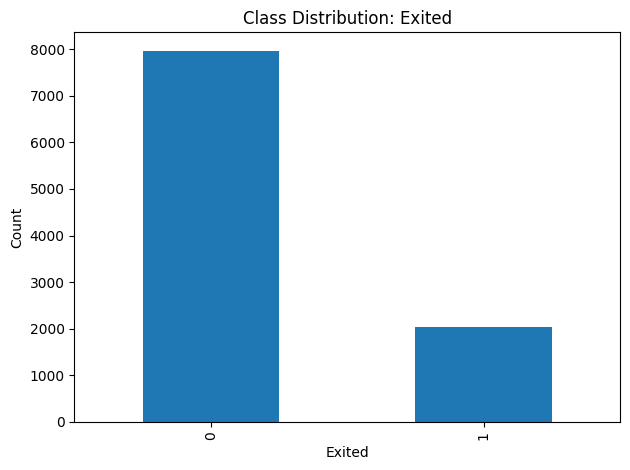

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
#load the dataset
df = pd.read_csv('Churn_Modelling.csv')

print('Shape:', df.shape)
display(df.head())

# Basic info
print('\\nColumns:', list(df.columns))
print('\\nMissing values per column:')
print(df.isna().sum())

# Class distribution
class_counts = df['Exited'].value_counts().sort_index()
print('\\nClass distribution (0=stay, 1=churn):\\n', class_counts)

# Plot class distribution (matplotlib only, no seaborn, no custom colors)
plt.figure()
class_counts.plot(kind='bar')
plt.title('Class Distribution: Exited')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Load data
df = pd.read_csv("Churn_Modelling.csv")

# 2) Feature engineering
def age_group(age):
    if age < 30:
        return "Under 30"
    elif age < 60:
        return "30-59"
    else:
        return "60+"

df["AgeGroup"] = df["Age"].apply(age_group)
df = pd.get_dummies(df, columns=["AgeGroup", "Geography"], drop_first=True)

df["ManyProducts"] = (df["NumOfProducts"] > 2).astype(int)

df["LowEngagementUser"] = ((df["NumOfProducts"] == 1) & (df["IsActiveMember"] == 0)).astype(int)

df["HighRisk_AgeBalance"] = (
    (df["Age"] >= 45) & (df["Age"] <= 55) &
    (df["Balance"] >= 80000) & (df["Balance"] <= 150000)
).astype(int)

# 3) Build X, y
df_model = df.drop(["RowNumber", "CustomerId", "Surname", "Gender", "HasCrCard"], axis=1)
X = df_model.drop("Exited", axis=1)
y = df_model["Exited"]

# 4) Train/test split (reproducible, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 5) Train RF (CV-tuned params you used)
rf_final = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=12,
    class_weight='balanced',
    random_state=42
)
rf_final.fit(X_train, y_train)

# 6) Probabilities + segmented thresholds
y_prob = rf.predict_proba(X_test)[:, 1]

# High-risk definition from our best run: ManyProducts==1 and Age in [35, 50]
is_high_risk = (X_test["ManyProducts"] == 1) & (X_test["Age"].between(35, 50))

thr_high_risk = 0.30
thr_normal   = 0.50

y_pred_segmented = (
    ((y_prob >= thr_high_risk) & is_high_risk) |
    ((y_prob >= thr_normal) & ~is_high_risk)
).astype(int)

# 7) Metrics
print("Segmented Threshold Approach (0.30 / 0.50):")
print("Accuracy :", round(accuracy_score(y_test, y_pred_segmented), 4))
print("Precision:", round(precision_score(y_test, y_pred_segmented), 4))
print("Recall   :", round(recall_score(y_test, y_pred_segmented), 4))
print("F1       :", round(f1_score(y_test, y_pred_segmented), 4))


Segmented Threshold Approach (0.30 / 0.50):
Accuracy : 0.835
Precision: 0.5854
Recall   : 0.6486
F1       : 0.6154


                Feature  Importance
1                   Age    0.255751
4         NumOfProducts    0.127526
3               Balance    0.116947
6       EstimatedSalary    0.085613
0           CreditScore    0.083244
12    LowEngagementUser    0.074379
11         ManyProducts    0.063854
2                Tenure    0.048461
9     Geography_Germany    0.041355
13  HighRisk_AgeBalance    0.041002
5        IsActiveMember    0.028706
8     AgeGroup_Under 30    0.014529
10      Geography_Spain    0.011288
7          AgeGroup_60+    0.007345


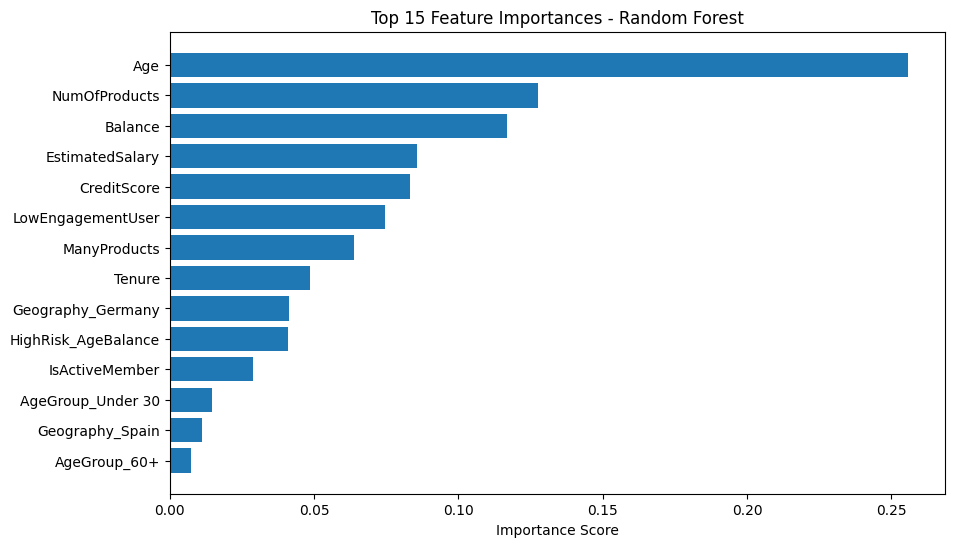

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_final.feature_importances_
features = X_train.columns

# Create DataFrame
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 15 features
print(feat_df.head(15))

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'].head(15), feat_df['Importance'].head(15))
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances - Random Forest')
plt.show()


<Figure size 800x600 with 0 Axes>

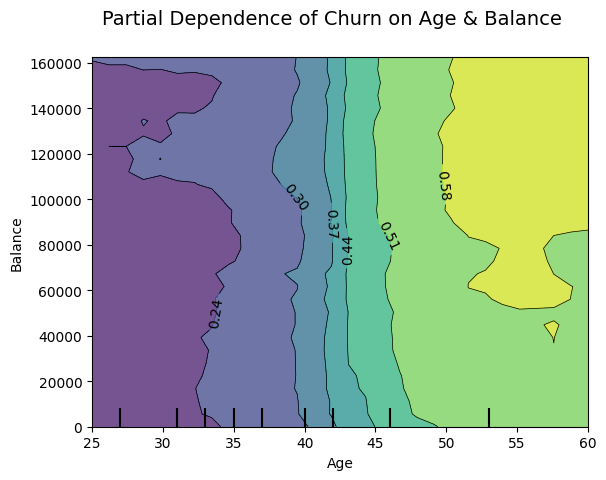

In [33]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Features we want to see together
features_2d = [('Age', 'Balance')]

# Create plot
fig = plt.figure(figsize=(8, 6))
display = PartialDependenceDisplay.from_estimator(
    rf_final,         # your trained Random Forest
    X_train,          # training data (no target)
    features=features_2d,
    kind='average',
    grid_resolution=30
)
plt.suptitle('Partial Dependence of Churn on Age & Balance', fontsize=14)
plt.show()


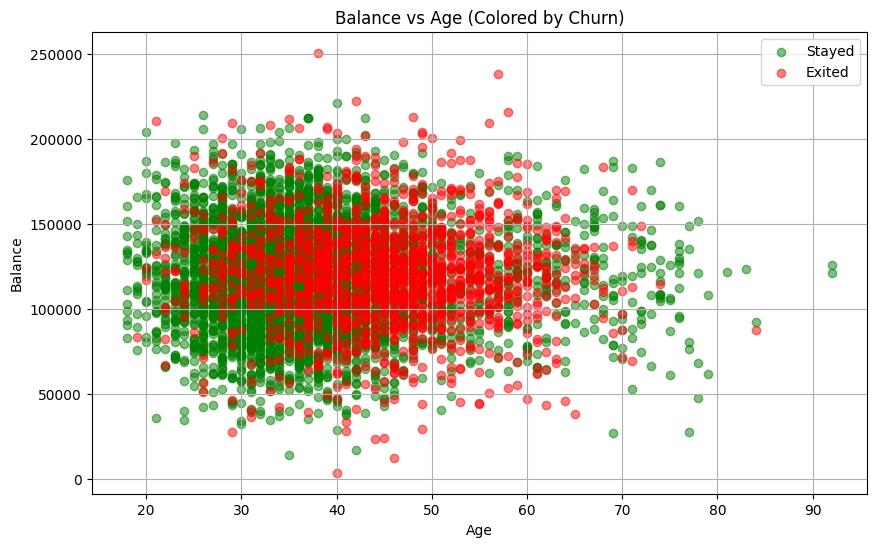

In [18]:
import matplotlib.pyplot as plt

# Load and clean
df = pd.read_csv('Churn_Modelling.csv')
df_nonzero = df[df['Balance'] > 0]

# Plot
plt.figure(figsize=(10, 6))

# Plot stayed customers (Exited = 0)
plt.scatter(df_nonzero[df_nonzero['Exited'] == 0]['Age'],
            df_nonzero[df_nonzero['Exited'] == 0]['Balance'],
            alpha=0.5, label='Stayed', color='green')

# Plot exited customers (Exited = 1)
plt.scatter(df_nonzero[df_nonzero['Exited'] == 1]['Age'],
            df_nonzero[df_nonzero['Exited'] == 1]['Balance'],
            alpha=0.5, label='Exited', color='red')

plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Balance vs Age (Colored by Churn)')
plt.legend()
plt.grid(True)
plt.show()


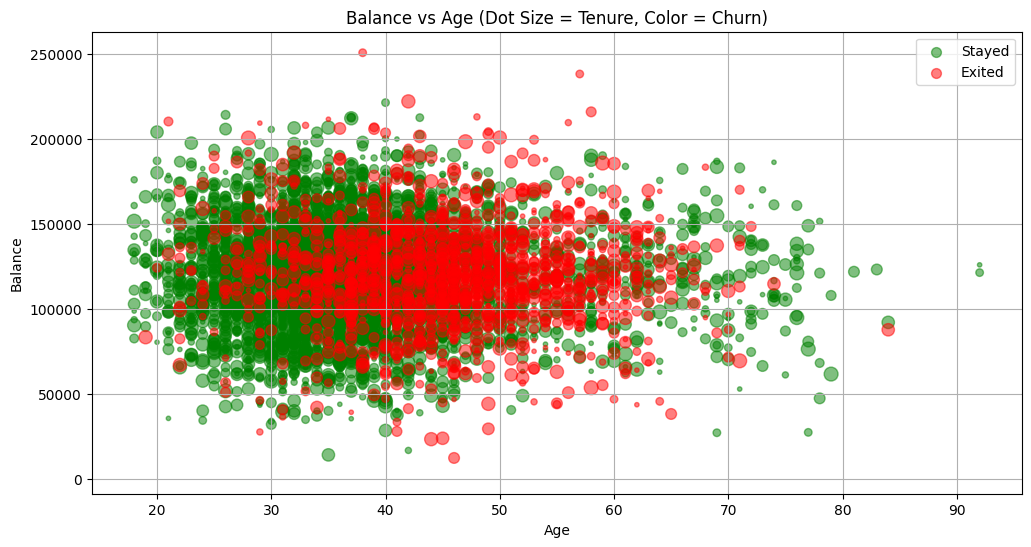

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Load and filter the dataset
df = pd.read_csv('Churn_Modelling.csv')
df_nonzero = df[df['Balance'] > 0]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Stayed customers
plt.scatter(
    df_nonzero[df_nonzero['Exited'] == 0]['Age'],
    df_nonzero[df_nonzero['Exited'] == 0]['Balance'],
    s=df_nonzero[df_nonzero['Exited'] == 0]['Tenure'] * 10,  # Size by Tenure
    alpha=0.5,
    label='Stayed',
    color='green'
)

# Plot Exited customers
plt.scatter(
    df_nonzero[df_nonzero['Exited'] == 1]['Age'],
    df_nonzero[df_nonzero['Exited'] == 1]['Balance'],
    s=df_nonzero[df_nonzero['Exited'] == 1]['Tenure'] * 10,  # Size by Tenure
    alpha=0.5,
    label='Exited',
    color='red'
)

# Labels and legend
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Balance vs Age (Dot Size = Tenure, Color = Churn)')
plt.legend()
plt.grid(True)
plt.show()
